<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/train_set/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch import functional as F
import torchvision
from d2l import torch as d2l
from torch.autograd import Variable
from matplotlib import pyplot as plt

In [ ]:
train_data = torchvision.datasets.FashionMNIST(
    root = 'FashionMNIST',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False
    )
test_data = torchvision.datasets.FashionMNIST(
    root = 'FashionMNIST',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False
    )

In [ ]:
train_iter = torch.utils.data.DataLoader(dataset=train_data,batch_size=50,shuffle=True)
test_iter = torch.utils.data.DataLoader(dataset=test_data,batch_size=50,shuffle=True)
images, labels = next(iter(train_iter))
t_iamges,t_labels = next(iter(test_iter))

In [ ]:
def get_title(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


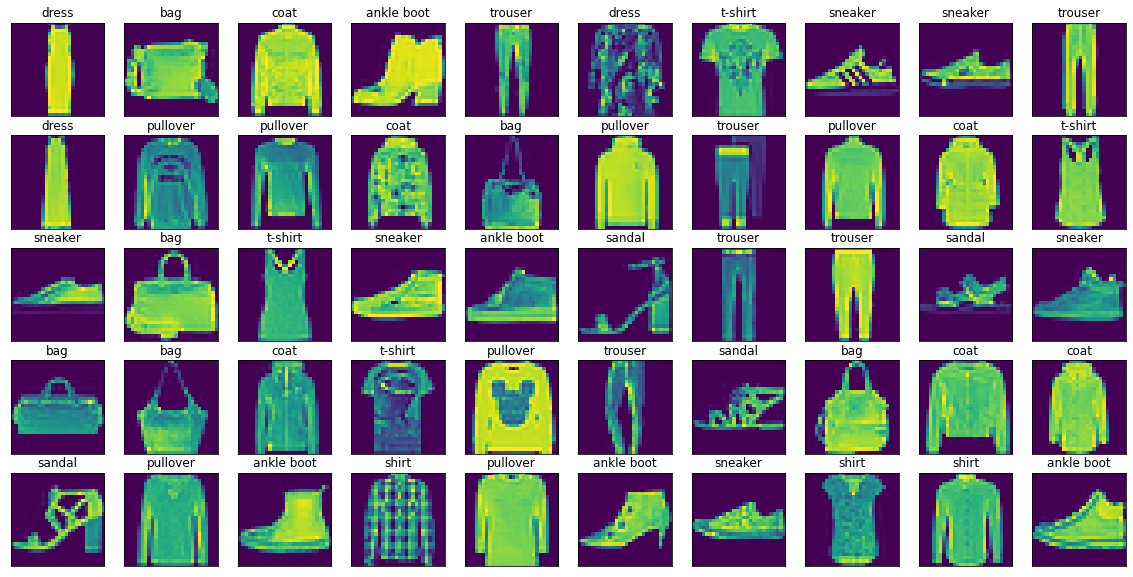

In [ ]:
img = images.permute(0,2,3,1)
img1 = t_iamges.permute(0,2,3,1)
d2l.show_images(img1,5,10,titles=get_title(t_labels),scale=2);

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Sequential(
                    nn.Conv2d(1,64,kernel_size=3,padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64,128,kernel_size=3,padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2,2))
        self.fc = nn.Sequential(
                nn.Linear(14*14*128,1024),
                nn.ReLU(),
                nn.Dropout(p=0.3),
                nn.Linear(1024,10))
    def forward(self,X):
        X = self.conv1(X)
        X = X.reshape(-1,14*14*128)
        X = self.fc(X)
        return X

In [ ]:
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1,self).__init__()
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,padding=1)
        self.branch1 = nn.Conv2d(64,128,kernel_size=1)
        self.branch2 = nn.Sequential(nn.Conv2d(64,128,kernel_size=1),nn.Conv2d(128,256,kernel_size=3,padding=1))
        self.branch3 = nn.Sequential(nn.Conv2d(64,128,kernel_size=1),nn.Conv2d(128,256,kernel_size=5,padding=2))
        self.branch4 = nn.Sequential(nn.MaxPool2d(kernel_size=3,stride=1,padding=1),nn.Conv2d(64,128,kernel_size=1))
        #self.conv2 = nn.Sequential(nn.Conv2d(192,256,kernel_size=3,padding=1),nn.ReLU())
        self.fc = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),nn.Linear(768,1024),nn.ReLU(),nn.Dropout(p=0.2),nn.Linear(1024,10))
    
    def forward(self,X):
        X = self.conv1(X)
        b1 = self.branch1(X)
        b2 = self.branch2(X)
        b3 = self.branch3(X)
        b4 = self.branch4(X)
        b = torch.cat((b1,b2,b3,b4),dim=1)
        Y = self.fc(b)
        return Y

In [ ]:
torch.cuda.empty_cache()
device = torch.device('cuda')
net = Net().to(device)
#net = Net_1().to(device)
net_1 = Net_1()
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
net_1

Net_1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (branch2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (branch3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (branch4): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=768, out_features=1024, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
epochs = 10
for epoch in range(epochs):
    sum_loss = 0.0
    train_correct = 0
    for data in train_iter:
        inputs, labels = data
        inputs,labels = Variable(inputs).cuda(),Variable(labels).cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cost(outputs,labels)
        loss.backward()
        optimizer.step()
        
        _, id = torch.max(outputs.data,1)
        sum_loss += loss.data
        train_correct += torch.sum(id == labels.data)
    print('[%d,%d] loss:%.3f' % (epoch+1,epochs,sum_loss/len(train_iter)))
    print('        correct:%.3f%%' % (100*train_correct/len(train_data)))

[1,10] loss:0.366
        correct:86.712%
[2,10] loss:0.220
        correct:91.908%
[3,10] loss:0.161
        correct:94.010%
[4,10] loss:0.116
        correct:95.750%
[5,10] loss:0.082
        correct:96.967%
[6,10] loss:0.056
        correct:97.912%
[7,10] loss:0.043
        correct:98.420%
[8,10] loss:0.033
        correct:98.842%
[9,10] loss:0.027
        correct:99.083%
[10,10] loss:0.024
        correct:99.188%


In [ ]:
net.eval()
test_correct = 0
for data in test_iter:
    inputs,labels = data
    inputs,labels = Variable(inputs).cuda(),Variable(labels).cuda()
    outputs = net(inputs)
    _, id = torch.max(outputs.data,1)
    test_correct += torch.sum(id == labels.data)
print('correct:%.3f%%'%(100*test_correct/len(test_data)))

correct:92.530%


In [ ]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)